In [41]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from timeit import default_timer as timer
import warnings
warnings.filterwarnings('ignore')

from skimage import io
import skimage.segmentation as seg
from skimage.filters import gaussian
from skimage.measure import moments
from skimage.morphology import remove_small_holes, remove_small_objects
import numpy.polynomial.polynomial as poly

print("Imports Loaded")

Imports Loaded


Number of rows zero     : [155, 156, 157]
Middle row zero         : 156
Top Image Dimension     : (156, 320)
Bottom Image Dimension  : (164, 320)
Top center cord:        : (163, 76)
Bottom center cord      : (157, 76)
Bot cen cord Orig IMG   : (157, 232)
************************************************************************************************************************
SUB REGION [(141.0, 150.0), (150.0, 159.0), (159.0, 168.0), (168.0, 177.0), (177.0, 186.0)]
SUB REGION START :  177.0
SUB REGION END :  186.0
SUB REGION DISTANCE [22.98857805042418, 24.243015809727112, 23.700261457484924, 22.41970937796916, 21.460753955451473]
TIME IT TOOK:  1.8385098055005074


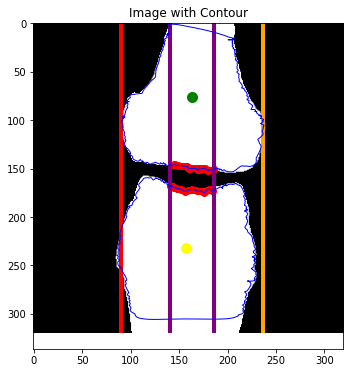

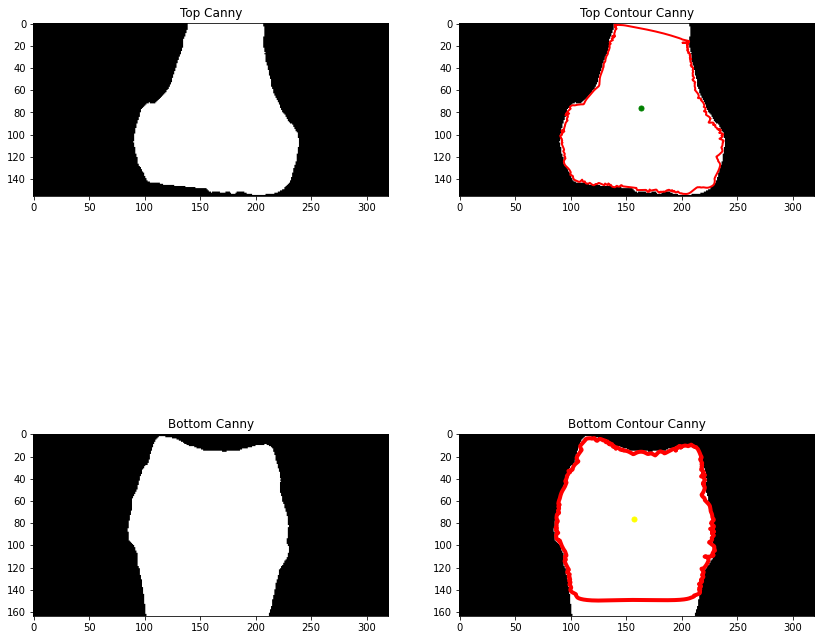

In [49]:
def circle_points(resolution, center, radius):
    radians = np.linspace(0, 2*np.pi, resolution)
    x = center[1] + radius*np.cos(radians)
    y = center[0] + radius*np.sin(radians)
    return np.array([x,y]).T

def get_center(contour: np.ndarray):
    """
    Finds the center of an active contour output array.
    :param contour: [:, 2] np.ndarray output from scikitlearn active_contour
    :return: tuple (x, y) central point of contour
    """
    center_x = contour[:,0]
    center_y = contour[:,1]
    center_x = center_x.astype(np.int)
    center_y = center_y.astype(np.int)
    center_x[center_x < 0] = 0
    center_y[center_y < 0] = 0
    
    min_x, max_x = np.min(center_x), np.max(center_x)
    min_y, max_y = np.min(center_y), np.max(center_y)
    
    center_pt = ( (min_x + max_x)//2,  (min_y + max_y)//2)
    return center_pt

def get_points(contour: np.ndarray):
    """
    Finds the min and max x of a contour
    :param contour: [:, 2] np.ndarray output from scikitlearn active_contour
    :return: tuple (min x, max x)
    """
    cord_x = contour[:,0]
    cord_y = contour[:,1]

    cord_x = cord_x.astype(np.int)
    cord_y = cord_y.astype(np.int)

    cord_x[cord_x < 0] = 0
    cord_y[cord_y < 0] = 0

    min_x, max_x = np.min(cord_x), np.max(cord_x)
    return min_x, max_x
    
def image_contour(image, split_point, show_plots = True):
    start = timer()
    #findind the middle row of 0
    col_sum = np.sum(image, axis = 1)
    rows_zero = np.argwhere(col_sum == 0)
    rows_zero = [x[0] for x in rows_zero]
    middle_zero = rows_zero[len(rows_zero) // 2]
    print('Number of rows zero     :', rows_zero)
    print('Middle row zero         :', middle_zero)
    
    bottom_zero_row = image[middle_zero:]
    top_zero_row = image[:middle_zero]
    print('Top Image Dimension     :', top_zero_row.shape)
    print('Bottom Image Dimension  :', bottom_zero_row.shape)
    
    # setting active contour
    top_contour = seg.active_contour(gaussian(top_zero_row), split_point, alpha = 0.015, beta = 10, bc = 'periodic', w_line = 1)
    bottom_contour = seg.active_contour(gaussian(bottom_zero_row), split_point, alpha = 0.015, beta = 10, bc = 'periodic', w_line = 1)
    
    # retreive the centroid coordinates of top and bottom contour
    top_center = get_center(top_contour)
    bottom_center = get_center(bottom_contour)
    bottom_center_adjusted = (bottom_center[0], bottom_center[1] + middle_zero)
    print('Top center cord:        :', top_center)
    print('Bottom center cord      :', bottom_center)
    print('Bot cen cord Orig IMG   :', bottom_center_adjusted)
    print('***' * 40)
    
    '''
    # line that passes through top and bottom centroid
    middle_xline = [top_center[0], bottom_center_adjusted[0]]
    middle_yline = [top_center[1], bottom_center_adjusted[1]]
    middle_full_line = [middle_xline, middle_yline]
    print('Middle line array        :', middle_full_line)
    '''
    
    # variables of min and max of the contour
    top_min_x, top_max_x = get_points(top_contour)
    bottom_min_x, bottom_max_x = get_points(top_contour)

    min_x = min(top_min_x, bottom_min_x)
    max_x = max(top_max_x, bottom_max_x)
    
    middle_x = (min_x + max_x) // 2
    
    # Find x0 and x1
    length_x = max_x - min_x 
    x0 = ((.7 * length_x) // 2) + min_x
    x1 = max_x - ((.7 * length_x) // 2)
    xrange = np.arange(x0, x1)
    
    # finding the middle cutting point
    top_middle_cut = top_contour[np.argwhere(x0 < top_contour[:, 0])[:, 0]]
    top_middle_cut = top_middle_cut[np.argwhere(top_middle_cut[:, 0] < x1)[:, 0]]
    top_middle_cut = top_middle_cut[np.argwhere(top_middle_cut[:, 1] > top_center[1])[:, 0]]
    top_pfit = poly.Polynomial(poly.polyfit(top_middle_cut[:, 0], top_middle_cut[:, 1], deg=3))
    top_pfit_all = top_pfit(xrange)

    bottom_middle_cut = bottom_contour[np.argwhere(x0 < bottom_contour[:, 0])[:, 0]]
    bottom_middle_cut = bottom_middle_cut[np.argwhere(bottom_middle_cut[:, 0] < x1)[:, 0]]
    bottom_middle_cut = bottom_middle_cut[np.argwhere(bottom_middle_cut[:, 1] < bottom_center[1])[:, 0]]
    bottom_pfit = poly.Polynomial(poly.polyfit(bottom_middle_cut[:, 0], bottom_middle_cut[:, 1], deg=3))
    bottom_pfit_all = bottom_pfit(xrange)

    bottom_middle_cut[:, 1] += middle_zero
    bottom_pfit_all += middle_zero

    subregion_length = (x1 - x0) // 5  # 5 subregions
    subregions_top = []
    subregions_bottom = []
    subregion_dists = []
    subregions = []

    for region_index in range(5):
        subregion_start = x0 + (region_index * subregion_length)
        if region_index < 4:
            subregion_end = subregion_start + subregion_length
        else:
            subregion_end = x1
        subregions.append((subregion_start, subregion_end))
        subregion_xrange = np.arange(subregion_start, subregion_end)
        subregion_top_y = top_pfit(subregion_xrange)
        subregion_bottom_y = bottom_pfit(subregion_xrange) + middle_zero

        subregions_top.append(np.array([[x, y] for x, y in zip(subregion_xrange, subregion_top_y)]))
        subregions_bottom.append(np.array([[x, y] for x, y in zip(subregion_xrange, subregion_bottom_y)]))

        dists = subregion_bottom_y - subregion_top_y
        subregion_dists.append(np.average(dists))

    print('SUB REGION', subregions)
    print('SUB REGION START : ', subregion_start)
    print('SUB REGION END : ', subregion_end)
    print('SUB REGION DISTANCE', subregion_dists)
    
    #5 sub rectangle
    #subregion_rect = Rectangle(subregion_start, dists + subregion_dists, subregion_end - subregion_start , subregion_dists)

    
    #back up to merge back into full image
    backup = bottom_contour.copy()
    bottom_contour[:,1]+=middle_zero
    
    #timer
    end = timer()
    print('TIME IT TOOK: ', end - start)
    
    # Image plot workspace
    plt.figure(figsize=(6,6))
    plt.imshow(image, cmap = 'gray')
    plt.title('Image with Contour')
    plt.plot(top_contour[:, 0], top_contour[:, 1], '-b', lw = 1)
    plt.plot(bottom_contour[:, 0], bottom_contour[:, 1], '-b', lw = 1)
    plt.plot([top_center[0],], [top_center[1],], marker = 'o', markersize = 10, color = 'green')
    plt.plot([bottom_center_adjusted[0],], [bottom_center_adjusted[1],], marker = 'o', markersize = 10, color = 'yellow')
    #plt.plot(middle_xline, middle_yline)
    plt.vlines(min_x, 0, image.shape[1], colors='red', lw = 4)
    plt.vlines(max_x, 0, image.shape[1], colors='orange', lw = 4)
    #plt.vlines(middle_x, 0, image.shape[1], colors='purple')
    plt.vlines(x0, 0, image.shape[1], color = 'purple', lw = 4)
    plt.vlines(x1, 0, image.shape[1], color = 'purple', lw = 4)
    plt.scatter(top_middle_cut[:, 0], top_middle_cut[:, 1], c='r')
    #plt.plot(xrange, top_pfit_all, '-o')
    plt.scatter(bottom_middle_cut[:, 0], bottom_middle_cut[:, 1], c='r')
    #plt.plot(xrange, bottom_pfit_all, '-o')
    #plt.add_patch(subregion_rect)
    plt.show()
    
    
    #Graphs for the splitted top and bottom 
    fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(14,14))
    
    if show_plots:
        ax[0,0].imshow(top_zero_row, cmap = 'gray')
        ax[0,0].set_title('Top Canny')
       
        ax[1,0].imshow(bottom_zero_row, cmap = 'gray')
        ax[1,0].set_title('Bottom Canny')
        
        ax[0,1].imshow(top_zero_row, cmap = 'gray')
        ax[0,1].set_title('Top Contour Canny')
        #ax[0,1].plot(split_point[:, 0], split_point[:, 1], '--r', lw = 4)
        ax[0,1].plot(top_contour[:, 0], top_contour[:, 1], '-r', lw = 2)
        ax[0,1].plot([top_center[0],], [top_center[1],], marker = 'o', markersize = 5, color = 'green')
        
        ax[1,1].imshow(bottom_zero_row, cmap = 'gray')
        ax[1,1].set_title('Bottom Contour Canny')
        #ax[1,1].plot(split_point[:, 0], split_point[:, 1], '--r', lw = 2)
        ax[1,1].plot(backup[:, 0], backup[:, 1], '-r', lw = 4)
        ax[1,1].plot([bottom_center[0],], [bottom_center[1],], marker = 'o', markersize = 5, color = 'yellow')

        plt.show()

def main():
    #Directory and reading the image as numpy array
    PATH_IMG = '/home/cheungt/BonesJSW/boneMEA/SegImage/9003815_v06_dip3_pred.png'
    #PATH_IMG = '/home/cheungt/BonesJSW/boneMEA/SegImage/9003815_v06_dip2_pred.png'
    
    #attempt 4 folder
    #PATH_IMG = '/home/cheungt/BonesJSW/boneMEA/new/9003316_dip4_pred.png'
    #PATH_IMG = '/home/cheungt/BonesJSW/boneMEA/new/9042459_dip3_pred.png'
    image = io.imread(PATH_IMG)
    image = remove_small_objects(image, 50)
    image = remove_small_holes(image, 50)

    split_point = circle_points(1000, [76, 160], 75)[:-1]
    image_contour(image, split_point)

main()